In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.tail(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
3748,21-03-2024,1035.599976,9903738,6715.750000,1806092,255.699997,10121220,149.949997,6212045,1445.750000,...,1772.150024,3783681,121.050003,38099730,744.299988,15161161,450.250000,18429233,841.599976,987716
3749,22-03-2024,1033.300049,9891194,6760.899902,1125238,259.799988,11402546,149.600006,8409218,1442.849976,...,1776.400024,7061283,122.750000,35001868,746.700012,15535921,460.100006,12531582,861.500000,1618543
3750,26-03-2024,1040.550049,9656767,6910.100098,1850321,261.549988,8259347,149.800003,7742995,1425.400024,...,1753.699951,5303630,123.949997,30860596,740.049988,14678342,461.399994,10475524,858.250000,1391794
3751,27-03-2024,1052.849976,17027308,7022.750000,1551275,258.750000,19196992,149.800003,20853016,1440.699951,...,1775.599976,8231130,122.750000,42673023,733.299988,30088789,445.600006,28138339,840.200012,1344329
3752,28-03-2024,1047.199951,10235318,7245.250000,3574518,264.049988,11966752,150.199997,7208707,1447.900024,...,1785.500000,6630072,124.400002,29453142,752.349976,21705116,451.000000,12637899,849.349976,5261416


In [3]:
feature_columns = ['BAJAJFIN', 'BAJAJFINVOL', 'ICICI', 'SBI', 'FEDBANK']
target_column = ['BAJAJFIN']
features = df[feature_columns]
target = df[target_column].shift(-5)

new_data1 = 7250.95
target.iloc[-5, 0] = new_data1

new_data2 = 7207.40
target.iloc[-4, 0] = new_data2

new_data3 = 7309.25
target.iloc[-3, 0] = new_data3

new_data4 = 7283.40
target.iloc[-2, 0] = new_data4

new_data5 = 7175.65
target.iloc[-1, 0] = new_data5

target.tail(5)

,BAJAJFIN
3748,7250.95
3749,7207.40
3750,7309.25
3751,7283.40
3752,7175.65


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

n_steps = 5  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_bajajfin5h_0.8262.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.8262
MAPE: 0.0354
RMSE: 308.7878
RMSE_normalizeddata: 0.0378
MAE_normalizeddata: 0.0288
MAE: 235.0410


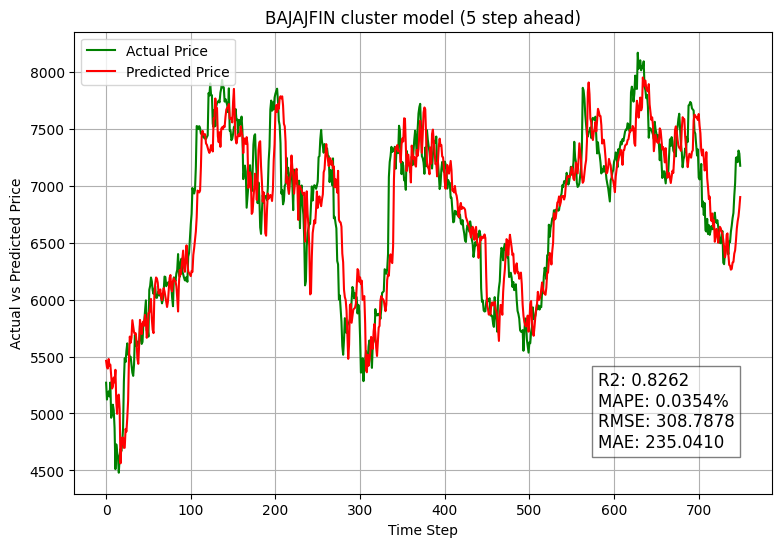

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('BAJAJFIN cluster model (5 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('bajajfincluster_5sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
R2: 0.9932
MAPE: 0.2754
RMSE: 116.0392
RMSE_normalizeddata: 0.0142
MAE_normalizeddata: 0.0076
MAE: 62.0188


In [25]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0049 - val_loss: 0.0032
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3439e-04 - val_loss: 0.0039
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4079e-04 - val_loss: 0.0028
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2339e-04 - val_loss: 0.0037
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.0216e-04 - val_loss: 0.0024
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3943e-04 - val_loss: 0.0023
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4294e-04 - val_loss: 0.0029
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7190e-04 - val_loss: 0.0024
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8379e-04 - val_loss: 0.0020
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.1942e-04 - val_loss: 0.0021
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5925e-04 - val_loss: 0.0

In [26]:
model_lstm.save('model_lstm_SBI5_1.keras')

In [27]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0050 - val_loss: 0.0150
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4828e-04 - val_loss: 0.0033
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7455e-04 - val_loss: 0.0064
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3992e-04 - val_loss: 0.0025
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6817e-04 - val_loss: 0.0022
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9170e-04 - val_loss: 0.0021
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5563e-04 - val_loss: 0.0038
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6548e-04 - val_loss: 0.0024
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9259e-04 - val_loss: 0.0021
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4001e-04 - val_loss: 0.0023
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2348e-04 - val_loss: 0.0020


In [28]:
model_lstm.save('model_lstm_SBI5_2.keras')

In [29]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0071 - val_loss: 0.0034
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3040e-04 - val_loss: 0.0024
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3953e-04 - val_loss: 0.0036
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.2974e-04 - val_loss: 0.0022
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0285e-04 - val_loss: 0.0022
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.8517e-04 - val_loss: 0.0018
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7510e-04 - val_loss: 0.0029
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 2.6682e-04 - val_loss: 0.0053
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0409e-04 - val_loss: 0.0039
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2806e-04 - val_loss: 0.0022
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.2178e-04 - val_loss

In [30]:
model_lstm.save('model_lstm_SBI5_3.keras')

In [31]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1778e-04 - val_loss: 0.0049
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.1905e-04 - val_loss: 0.0043
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9567e-04 - val_loss: 0.0028
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1149e-04 - val_loss: 0.0030
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.3461e-04 - val_loss: 0.0027
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8449e-04 - val_loss: 0.0034
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6440e-04 - val_loss: 0.0026
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.7810e-04 - val_loss: 0.0022
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.2199e-04 - val_loss: 0.0028
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.0856e-04 - val_los

In [32]:
model_lstm.save('model_lstm_SBI5_4.keras')

In [33]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.2876e-04 - val_loss: 0.0066
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.1736e-04 - val_loss: 0.0182
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.7652e-04 - val_loss: 0.0031
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8397e-04 - val_loss: 0.0036
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8151e-04 - val_loss: 0.0057
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.7112e-04 - val_loss: 0.0019
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.7822e-04 - val_loss: 0.0021
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8394e-04 - val_loss: 0.0038
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6238e-04 - val_loss: 0.0020
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2214e-04 - val_loss

In [34]:
model_lstm.save('model_lstm_SBI5_5.keras')

In [35]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4530e-04 - val_loss: 0.0088
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 3.1037e-04 - val_loss: 0.0034
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 3.3788e-04 - val_loss: 0.0026
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.5928e-04 - val_loss: 0.0024
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.8613e-04 - val_loss: 0.0028
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8315e-04 - val_loss: 0.0022
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2936e-04 - val_loss: 0.0021
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1483e-04 - val_loss: 0.0036
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.3642e-04 - val_loss: 0.0019
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.7751e-04 - val_loss:

In [36]:
model_lstm.save('model_lstm_SBI5_6.keras')

In [37]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))


r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0072 - val_loss: 0.0060
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0098e-04 - val_loss: 0.0023
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.9662e-04 - val_loss: 0.0058
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.6717e-04 - val_loss: 0.0024
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0849e-04 - val_loss: 0.0023
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9156e-04 - val_loss: 0.0024
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 2.5105e-04 - val_loss: 0.0020
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8845e-04 - val_loss: 0.0022
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5698e-04 - val_loss: 0.0018
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6323e-04 - val_loss: 0.0021
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6284e-04 - val_loss

In [38]:
model_lstm.save('model_lstm_SBI5_7.keras')

In [39]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 0.0066 - val_loss: 0.0052
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1639e-04 - val_loss: 0.0025
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2946e-04 - val_loss: 0.0023
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2798e-04 - val_loss: 0.0061
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2278e-04 - val_loss: 0.0021
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8122e-04 - val_loss: 0.0024
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3386e-04 - val_loss: 0.0019
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.3060e-04 - val_loss: 0.0048
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8921e-04 - val_loss: 0.0019
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2.9597e-04 - val_loss: 0.0022
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.9002e-04 - val_loss

In [40]:
model_lstm.save('model_lstm_SBI5_8.keras')

In [41]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4667e-04 - val_loss: 0.0032
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2231e-04 - val_loss: 0.0039
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0065e-04 - val_loss: 0.0020
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.6966e-04 - val_loss: 0.0028
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1894e-04 - val_loss: 0.0021
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.6049e-04 - val_loss: 0.0021
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4661e-04 - val_loss: 0.0017
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3125e-04 - val_loss: 0.0017
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5317e-04 - val_loss: 0.0018
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1940e-04 - val_loss: 0

In [42]:
model_lstm.save('model_lstm_SBI5_9.keras')

In [43]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0077 - val_loss: 0.0128
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4859e-04 - val_loss: 0.0032
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9034e-04 - val_loss: 0.0034
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.9437e-04 - val_loss: 0.0025
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2495e-04 - val_loss: 0.0023
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5720e-04 - val_loss: 0.0029
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.6721e-04 - val_loss: 0.0022
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.8155e-04 - val_loss: 0.0026
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.0508e-04 - val_loss: 0.0019
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.4808e-04 - val_loss: 0.0022
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.6225e-04 - val_los

In [44]:
model_lstm.save('model_lstm_SBI5_10.keras')